In [17]:
from matplotlib import pyplot as plt, animation
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

%matplotlib notebook

# Upute za preuzimanje zadataka

Posjetiti stranicu *[Advent of Code](https://adventofcode.com)*. Na toj stranici napraviti acconut (moze se koristiti github/email) i kopirati svoj session. Pozvati fju get_aoc_input sa session_str jednakim session-u i danom i godinom zadatka.

In [57]:
session = '53616c7465645f5fa84cdf4fd1e667823de36970c380c49a1373a1ac0d5a4ddf77aeb87eda22f992bac9a4e24fa8295f06c385916e074b59f6ba4ee8e53b2612'

In [47]:
import requests
import os

def get_aoc_input(session_str, day, year, return_output=False):
    
    if os.path.exists(f'./{year}_{day}_input.txt'):
        with open(f'{year}_{day}_input.txt') as f:
            text = [x.strip() for x in f.readlines()]
        if return_output: return text
    else:
        response = requests.get(
            f'https://adventofcode.com/{year}/day/{day}/input',
            headers={'cookie':f'session={session_str}'}
        )
    
        try:
            with open(f'{year}_{day}_input.txt', 'w') as f:
                f.write(response.text)
            if return_output: return [x.strip() for x in response.text.strip().split('\n')]
        except Exception as e:
            print(f'Error: {e.args}')
            return None

# Experimental Emergency Teleportation
*[Link na zadatak](https://adventofcode.com/2018/day/23)*

In [51]:
import re
from collections import Counter

def parse_line(line):
    return tuple(map(int, re.match(r'pos=<(-?\d+),(-?\d+),(-?\d+)>, r=(\d+)', line).groups()))

def manh_dist(point1, point2):
    return sum(abs(point1[i] - point2[i]) for i in range(3))

inlist = get_aoc_input(session, 23, 2018, return_output=True)
inputs = [parse_line(line) for line in inlist]
c = Counter()
for n1 in inputs:
    for n2 in inputs:
        if manh_dist(n1,n2) <= n1[-1]:
            c[n1] += manh_dist(n1,n2) <= n1[-1]

n = sorted(c.keys(), key=lambda x: x[-1], reverse=True)[0]
print(c[n])

420


In [52]:
from z3 import *

def zabs(x):
    return If(x >= 0,x,-x)

(x,y,z) = (Int('x'),Int('y'),Int('z'))
in_ranges = [Int(f'in_range_{i}') for i in range(len(inputs))]
range_count = Int('sum')
dist_from_zero = Int('dist')

o = Optimize()
for i in range(len(inputs)):
    nx,ny,nz,nr = inputs[i]
    o.add(in_ranges[i] == If(zabs(x-nx) + zabs(y-ny) + zabs(z-nz) <= nr, 1, 0))   
o.add(range_count == sum(in_ranges))
o.add(dist_from_zero == zabs(x) + zabs(y) + zabs(z))

In [53]:
h1 = o.maximize(range_count)
h2 = o.minimize(dist_from_zero)
print(o.check())
print(o.lower(h2), o.upper(h2))

sat
124276103 124276103


# Lanternfish

*[Link na zadatak](https://adventofcode.com/2021/day/6)*

In [ ]:
from collections import deque
import re
import itertools as it

Dohvatimo input za zadatak i pocnimo :)

In [ ]:
get_aoc_input(session, 6, 2021)

Vidimo da je input jako lijepo formatiran (ako se radi u python-u ;), to se lako obradi uz malo `str`/`np.loadtxt` magije

# Rjesenje pomocu numpy-a

In [ ]:
lines = np.loadtxt('2021_6_input.txt', delimiter=',', dtype="uint32")
fish_timer = np.zeros(9)
time, count = np.unique(lines, return_counts=True)
fish_timer[time] = count

In [ ]:
def memoize_numpy(fish_timer, days):
    gen = np.copy(fish_timer)
    for _ in range(days):
        gen[7] += gen[0]
        gen = np.roll(gen, -1)
    return sum(gen)

In [ ]:
print(memoize_numpy(fish_timer, 80))
print(memoize_numpy(fish_timer, 256))

In [ ]:
def generator(fish_timer, days):
    for i in range(days):
        yield memoize_numpy(fish_timer, i)

y = [x for x in generator(fish_timer, 256)]

fig, ax = plt.subplots()
ax.plot(y)
plt.show()

# Rjesenje pomocu vulgaris python-a :)

In [ ]:
with open('2021_6_input.txt') as f:
    inlist = list(map(int, f.readline().strip().split(',')))
d = deque([0 for _ in range(9)])
for num in inlist:
    d[num] += 1

In [ ]:
def memoize_pure_python(deq, days):
    d = deque([x for x in deq])
    for _ in range(days):
        d[7] += d[0]
        d.rotate(-1)
    return sum(d)

In [ ]:
print(memoize_pure_python(d, 80))
print(memoize_pure_python(d, 256))

# Smoke Basin

*[Link na zadatak](https://adventofcode.com/2021/day/9)*

In [55]:
inlist = get_aoc_input(session, 9, 2021, return_output=True)
matrix = [[int(x) for x in line] for line in inlist]
matrixes = np.array([[[int(x) for x in line] for line in inlist]])

In [20]:
def check_low_spot(i,j,inlist,matrix):
    ok = True
    for (x,y) in [(1,0), (0,1), (-1,0), (0,-1)]:
        if -1 < y + j < len(inlist) and -1 < x + i < len(line):
            ok &= int(inlist[y+j][x+i]) > int(l)
    if ok:
        matrix[j][i] = 0
        return matrix, 1+int(l)
    else:
        matrix[j][i] = 6 if matrix[j][i] != 9 else 9
        return None, None

In [56]:
lows,s = [],0
for j,line in enumerate(inlist):
    for i,l in enumerate(line):
        m, n = check_low_spot(i,j,inlist,matrix)
        if m is not None:
            s += n
            lows.append((i,j))
            matrixes = np.append(matrixes, [m], axis=0)
print(s)

558


In [32]:
def basin_size(x,y,inlist):
    seen = set()
    Q = [(x,y)]
    size = 0
    while len(Q) > 0:
        curr = Q.pop(0)
        curx, cury = curr
        if curr in seen:
            continue
        seen.add(curr)
        if 0 <= cury < len(inlist) and 0 <= curx < len(inlist[0]):
            if int(inlist[cury][curx]) != 9:
                size += 1
                Q += [(curx+1,cury), (curx-1,cury), (curx,cury+1), (curx,cury-1)]
    return size

In [34]:
basins = []
for (x,y) in lows:
    basins.append(basin_size(x,y,inlist))
basins.sort()
print(f'Size of the largest three basins: {basins[-1]}, {basins[-2]}, {basins[-3]}')
print(f'Those numbers multiplied: {basins[-1] * basins[-2] * basins[-3]}')

Size of the largest three basins: 101, 94, 93
Those numbers multiplied: 882942


<IPython.core.display.Javascript object>


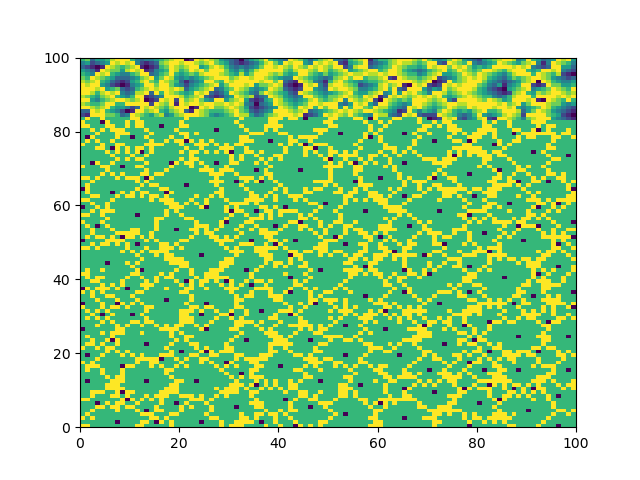

In [36]:
fig, ax = plt.subplots()
cax = ax.pcolormesh(matrixes[0, :, :])

In [37]:
def basin_animate(i):
    cax.set_array(matrixes[i, :, :])
    return cax

anim = animation.FuncAnimation(fig, basin_animate, interval=100, frames=matrixes.shape[0] - 1)
plt.show()